# Imports

In [1]:
import os
import time
import calmap
import pickle
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec
from astral import Astral
from matplotlib.pyplot import cm
from shapely.geometry import Point
from scipy.interpolate import UnivariateSpline

pd.options.display.max_rows = 999
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Data

In [6]:
saved_data = True # -- Load data from .pkl (faster).
holidays = [pd.datetime(2017, 7, 4), pd.datetime(2017, 9, 4)]

if not saved_data:
    # -- Read data and pivot to get full time series for each camera.
    # -- Then resample to 15 min, taking the sum of counts.
    df = pd.read_feather(os.path.join("..", "data", "results", "hadive-data.feather"))
    df = df.pivot_table(index="date", columns="cam_id", values="count").resample("15Min")
    df.mean().to_pickle(os.path.join("..", "data", "results", "hadive-data-resample.pkl"))
    df.std().to_pickle(os.path.join("..", "data", "results", "hadive-data-resample_std.pkl"))
else:
    df = pd.read_pickle(os.path.join("..", "data", "results", "hadive-data-resample.pkl"))
    df_std = pd.read_pickle(os.path.join("..", "data", "results", "hadive-data-resample_std.pkl"))

# -- Pull date & time in seperate columns.
df["d"] = df_std["d"] = [t[:10] for t in df.index.astype(str)]
df["t"] = df_std["t"] = [t[11:16] for t in df.index.astype(str)]

for dd in [df, df_std]:
    # -- Reshape data to get time series at each camera for each day.
    dd = dd.set_index("t") \
           .set_index(pd.to_datetime(dd["d"]), append=True) \
           .drop("d", axis=1).unstack(1).T
            
# df = df.set_index("t") \
#        .set_index(pd.to_datetime(df["d"]), append=True) \
#        .drop("d", axis=1).unstack(1).T
# df_std = df_std.set_index("t") \
#                .set_index(pd.to_datetime(df_std["d"]), append=True) \
#                .drop("d", axis=1).unstack(1).T

# -- Select time series (for each camera and day) with less than 1 hour of downtime.
df = df[df.isnull().sum(axis=1) < 4]
df_std = df_std[df_std.isnull().sum(axis=1) < 4]

# -- Fill remaining Nans with 0
df.fillna(0, inplace=True)
df_std.fillna(0, inplace=True)

# -- Normalize each day at each camera.
df = ((df.T - df.T.mean()) / df.T.std()).T

# -- Subset data in weekdays, weekends, holidays, and weekdays without holidays.
we = df[df.index.get_level_values(1).weekday >= 5]
wd = df[df.index.get_level_values(1).weekday < 5]
hd = df[df.index.get_level_values(1).isin(holidays)]
wd_wo_hd = wd[~wd.index.get_level_values(1).isin(holidays)]

wd.head(1)

t                     00:00     00:15     00:30     00:45     01:00     01:15  \
cam_id d                                                                        
112    2017-06-28 -0.318887 -0.318887 -0.318887 -0.318887 -0.318887 -0.318887   

t                     01:30     01:45     02:00     02:15    ...        21:30  \
cam_id d                                                     ...                
112    2017-06-28 -0.318887 -0.318887 -0.318887 -0.318887    ...    -0.318887   

t                     21:45     22:00     22:15     22:30     22:45     23:00  \
cam_id d                                                                        
112    2017-06-28 -0.318887 -0.318887 -0.318887 -0.318887 -0.318887 -0.318887   

t                     23:15     23:30     23:45  
cam_id d                                         
112    2017-06-28 -0.318887 -0.318887 -0.318887  

[1 rows x 96 columns]

t                     00:00     00:15     00:30     00:45     01:00     01:15  \
cam_id d                                                                        
112    2017-06-27       NaN       NaN       NaN       NaN       NaN       NaN   
       2017-06-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-06-29  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-06-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-06  0.000000  0.000000       NaN  0.000000  0.000000  0.000000   
       2017-07-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-09  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-16  0.389249  0.000000  0.000000  0.389249  0.301511  0.000000   
       2017-07-17  0.603023  0.288675  0.000000  0.301511  0.000000  0.000000   
       2017-07-18  0.000000  0.000000  0.404520  0.288675  0.000000  0.288675   
       2017-07-19  0.000000  0.000000  0.000000  0.000000  0.288675  0.000000   
       2017-07-20  0.301511  0.288675  0.000000  0.288675  0.000000  0.000000   
       2017-07-21  0.000000  0.000000  0.288675  0.000000  0.000000  0.000000   
       2017-07-22  0.000000  0.389249  0.000000  0.000000  0.301511  0.389249   
       2017-07-23  0.674200  0.000000  0.646670  0.288675  0.000000  0.000000   
       2017-07-24  0.301511  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-07-25  0.000000  0.000000  0.000000  0.288675  0.000000  0.000000   
       2017-07-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.288675   
       2017-07-27  0.000000  0.467099  0.389249  0.000000  0.000000  0.000000   
       2017-07-28  0.000000  0.000000  0.404520  0.000000  0.000000  0.301511   
       2017-07-29       NaN       NaN       NaN       NaN       NaN       NaN   
       2017-07-30       NaN       NaN       NaN       NaN       NaN       NaN   
       2017-07-31       NaN       NaN       NaN       NaN       NaN       NaN   
       2017-08-01       NaN       NaN       NaN       NaN       NaN       NaN   
       2017-08-02  0.301511  0.000000  0.301511  0.000000  0.000000  0.301511   
       2017-08-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-08-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       2017-08-05  0.288675  0.000000  0.000000  0.301511  0.000000  0.000000   
       2017-08-06  0.404520  0.301511  0.404520  0.000000  0.301511  0.301511   
       2017-08-07  0.000000  0.404520  0.000000  0.000000  0.000000  0.000000   
       2017-08-08  0.316228  0.288675  0.301511  0.000000  0.467099  0.000000   
       2017-08-09  0.687552  0.301511  0.301511  0.301511  0.404520  0.000000   
       2017-08-10  0.000000  0.000000  0.000000  0.447214  0.000000  0.000000   
       2017-08-11  0.547723  0.894427  0.500000  0.000000  0.447214  0.000000   
       2017-08-12  0.000000  0.000000  0.500000  0.000000  0.000000  0.000000   
       2017-08-13  0.000000  0.

In [3]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(1)

cam_id cctv_id         description        lat       long  people  ribbon  \
0     112      83  SIE @ Richmond Ave  40.614885 -74.157435       0       1   

            boro zipcode  
0  Staten Island   10314

In [4]:
prec = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"], index_col="DATE")
prec["d"] = prec.index.strftime("%Y-%m-%d").tolist()
prec.head(1)

PRCP           d
DATE                        
2017-01-01   0.0  2017-01-01

# Live Time
Uses calmap library to produce a figure showing the amount of observations recorded per day.

/Users/JordanVani/anaconda/lib/python2.7/site-packages/calmap/__init__.py:294: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  by_day = data.resample('D', how=how)
/Users/JordanVani/anaconda/lib/python2.7/site-packages/calmap/__init__.py:146: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  linecolor = ax.get_axis_bgcolor()


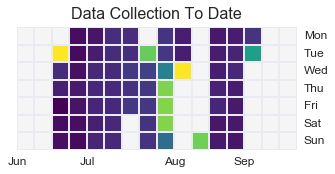

In [6]:
saved_data = True

if not saved_data:
    # -- Load original data. Resample by day, and get counts of observations.
    live_time = pd.read_feather(os.path.join("..", "data", "results", "hadive-data.feather")
                               ).set_index("date").resample("D").size()
    live_time.to_pickle(os.path.join("..", "data", "results", "live-time.pkl"))
else:
    live_time = pd.read_pickle(os.path.join("..", "data", "results", "live-time.pkl"))

# -- Plot.
fig, [ax] = calmap.calendarplot(live_time[live_time != 0], cmap="viridis_r", 
                                fig_kws=dict(figsize=(10,2)))

ax.set_ylabel("")
ax.set_xlim(6*4, 10*4)
# ax.set_xticklabels(ax.get_xticklabels(), ha="left")
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_title("Data Collection To Date", fontsize=16, y=1.02)

fig.savefig("../outputs/plots/data_collection.png", bbox_inches='tight')

# Borough Averages
Shows foot traffic trends for weekdays, weekends, and holidays with standard error +/-. The averages (for weekdays, weekend, and holidays) are found by:
1. Getting the average count at each camera within a 15 minute interval.
2. Mean normalizing the timeseries at each camera.
3. Taking the mean & standard deviation across mean normalized cameras.
4. Standard error is calculated using the std dev across camera time series' and the cameras (N) in the borough( sample).

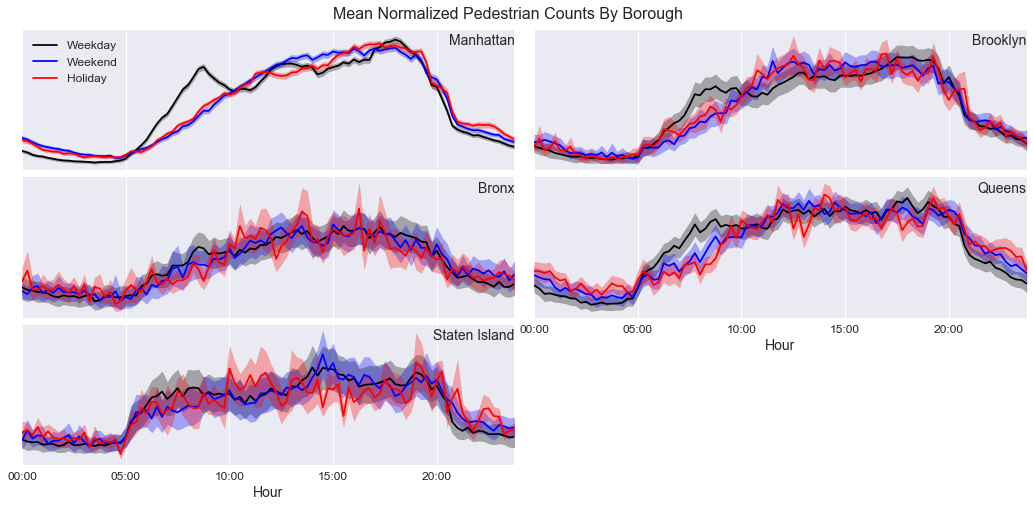

In [109]:
saved_data = True
bb = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"]

fig, [r1, r2, r3] = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(18, 8))
fig.delaxes(r3[1])

for boro, ax in zip(bb, np.hstack([r1, r2, r3])):    
    # -- Get cam_id for relevant cameras in boro.
    cams_b = cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values
    
    # -- Select cameras for boro and days without rain.
    wd_wo_hd_b = wd_wo_hd[(wd_wo_hd.index.get_level_values(0).astype("float64").isin(cams_b)) & 
                          (wd_wo_hd.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]
    we_b = we[(we.index.get_level_values(0).astype("float64").isin(cams_b)) & 
              (we.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]
    hd_b = hd[(hd.index.get_level_values(0).astype("float64").isin(cams_b)) & 
              (hd.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]
    
    # -- Get mean time series.
    wd_wo_hd_b_mean = wd_wo_hd_b.groupby(level=0).mean().mean()
    we_b_mean = we_b.groupby(level=0).mean().mean()
    hd_b_mean = hd_b.groupby(level=0).mean().mean()
    
    # -- Get standard deviation of the normalized 15-min time series at each camera.
    wd_std = wd_wo_hd_b.groupby(level=0).std()
    we_std = we_b.groupby(level=0).std()
    hd_std = hd_b.groupby(level=0).std()
    
    # -- Calculate the standard error in the mean across cameras.
    wd_std_err = np.sqrt(((wd_std ** 2).sum() / len(wd_std))) / np.sqrt(len(wd_std))
    we_std_err = np.sqrt(((we_std ** 2).sum() / len(we_std))) / np.sqrt(len(we_std))
    hd_std_err = np.sqrt(((hd_std ** 2).sum() / len(hd_std))) / np.sqrt(len(hd_std))
    
    # -- Plot +/- standard error.
    ax.fill_between(range(len(wd_wo_hd_b_mean.index)), 
                    wd_wo_hd_b_mean + wd_std_err, wd_wo_hd_b_mean - wd_std_err, 
                    color="k", alpha=0.3)
    ax.fill_between(range(len(we_b_mean.index)), 
                    we_b_mean + we_std_err, we_b_mean - we_std_err, 
                    color="b", alpha=0.3)
    ax.fill_between(range(len(hd_b_mean.index)), 
                    hd_b_mean + hd_std_err, hd_b_mean - hd_std_err, 
                    color="r", alpha=0.3)

    # -- Plot mean.
    wd_wo_hd_b_mean.plot(ax=ax, c="k")
    we_b_mean.plot(ax=ax, c="b")
    hd_b_mean.plot(ax=ax, c="r")
        
    ax.set_yticklabels([])
    ax.set_xlabel("Hour", fontsize=14)
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.grid(False)
    ax.grid(True, which="both", axis="x")
    ax.text(ax.get_xlim()[1] * 0.999999, ax.get_ylim()[1] * 0.95, 
            boro, fontsize=14, va="top", ha="right")

r2[1].set_xticklabels(list(r3[0].get_xticklabels()))
[label.set_visible(True) for label in r2[1].get_xticklabels()]
r1[0].legend(r1[0].get_lines(), ["Weekday", "Weekend", "Holiday"], fontsize=12)
fig.suptitle("Mean Normalized Pedestrian Counts By Borough", y=0.92, fontsize=16)
fig.subplots_adjust(hspace=0.05, wspace=0.04)

fig.savefig("../outputs/plots/ped_line_boro.png", bbox_inches='tight')

# Manhattan Time Series Image

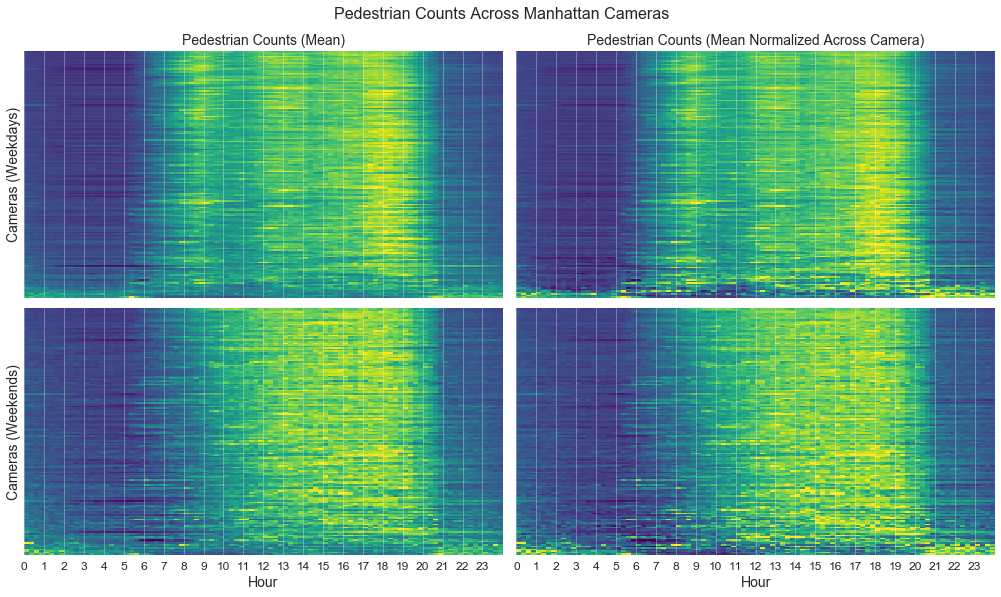

In [227]:
# -- Get cam_id for relevant cameras in Manhattan.
mn_cams = cams[(cams.boro == "Manhattan") & (cams.people == 1)].cam_id.values

# -- Select cameras for boro.
mn_we = we[(we.index.get_level_values(0).astype("float64").isin(mn_cams)) & 
           (we.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]
mn_wd = wd[(wd.index.get_level_values(0).astype("float64").isin(mn_cams)) & 
           (wd.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]

# -- Calculate mean time series for each camera, sorting by mean value.
mn_wd_mean = mn_wd.groupby(level=0).mean()
mn_wd_mean = mn_wd_mean.iloc[np.flipud(mn_wd_mean.iloc[:, 24:80].mean(axis=1).argsort())]
mn_we_mean = mn_we.groupby(level=0).mean()
mn_we_mean = mn_we_mean.iloc[np.flipud(mn_we_mean.iloc[:, 24:80].mean(axis=1).argsort())]

# -- Plot.
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))

wd_im = ax1.imshow(mn_wd_mean, cmap="viridis", aspect="auto")
wd_im_ = ax2.imshow(((mn_wd_mean.T - mn_wd_mean.T.mean()) / mn_wd_mean.T.std()).T, 
                    cmap="viridis", aspect="auto")
we_im = ax3.imshow(mn_we_mean, cmap="viridis", aspect="auto")
we_im_ = ax4.imshow(((mn_we_mean.T - mn_we_mean.T.mean()) / mn_we_mean.T.std()).T, 
                    cmap="viridis", aspect="auto")

ax1.set_title("Pedestrian Counts (Mean)", fontsize=14)
ax2.set_title("Pedestrian Counts (Mean Normalized Across Camera)", fontsize=14)

for ax in fig.get_axes():
    ax.grid(alpha=0.3)
    ax.grid(False, axis="y")
    ax.set_yticklabels([])
    ax.set_xticklabels(range(24))
    ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
    ax.tick_params(axis="both", which="both", labelsize=12)
    
for ax in [ax3, ax4]:
    ax.set_xlabel("Hour", fontsize=14)

for iml, imr in zip([wd_im, we_im], [wd_im_, we_im_]):
    iml.set_clim(-1.75, 1.75)
    imr.set_clim(-2, 2)  
    
ax1.set_ylabel("Cameras (Weekdays)", fontsize=14, labelpad=-4)
ax3.set_ylabel("Cameras (Weekends)", fontsize=14, labelpad=-4)

fig.suptitle("Pedestrian Counts Across Manhattan Cameras", fontsize=16, y=1.03)
fig.tight_layout()

fig.savefig("../outputs/plots/ped_im_mn.png", bbox_inches='tight')

# Manhattan Day of Week Images

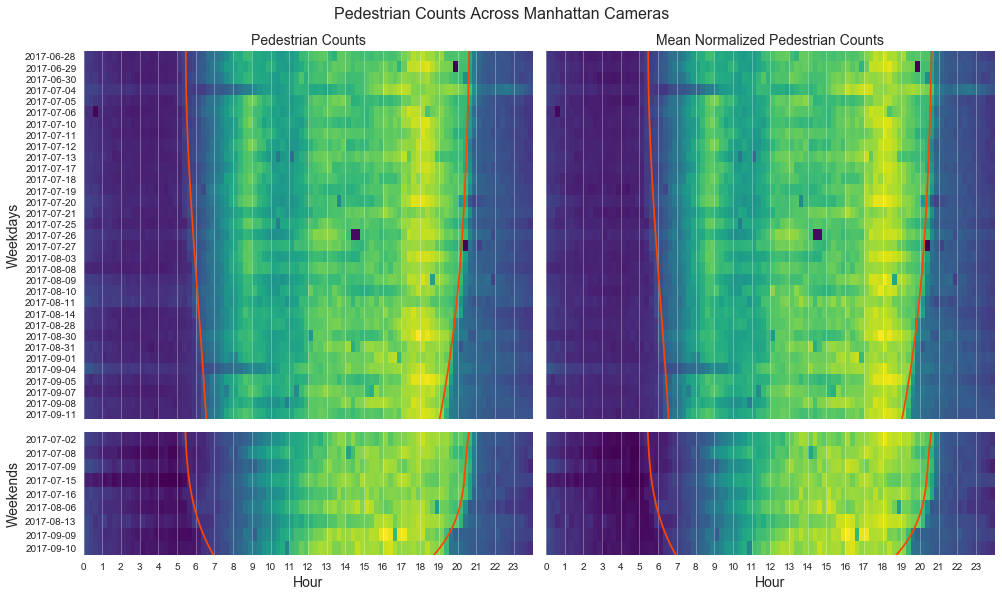

In [226]:
mn_wd_ts = mn_wd.groupby(level=1).mean()
mn_we_ts = mn_we.groupby(level=1).mean()

fig, [r1, r2] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8),
                             gridspec_kw={"height_ratios": [3, 1]})

for [axl, axr], dd in zip([r1, r2], [mn_wd_ts, mn_we_ts]):
    
    axl.imshow(dd, cmap="viridis", aspect="auto")
    axl.set_yticks(range(len(dd.index)))
    axl.set_yticklabels(dd.index.date)
    
    # -- Normalize each day.
    axr.imshow(((dd.T - dd.T.mean()) / dd.T.std()).T, cmap="viridis", aspect="auto")
    axr.set_yticklabels([])
    
    xx_ss, yy_ss, xx_sr, yy_sr = [], [], [], []
    for ii, idx in enumerate(pd.to_datetime(dd.index)):
        sunset = nyc_astral.sun(date=idx, local=True)["sunset"]
        ss = (sunset.hour * 3600 + sunset.minute * 60 + sunset.second) / (15 * 60)
        xx_ss.append(ss)
        yy_ss.append(ii)
        sunrise = nyc_astral.sun(date=idx, local=True)["sunrise"]
        sr = (sunrise.hour * 3600 + sunrise.minute * 60 + sunrise.second) / (15 * 60)
        xx_sr.append(sr)
        yy_sr.append(ii)
        
    spl_ss = UnivariateSpline(yy_ss, xx_ss)
    xs = np.linspace(-0.5, len(dd) - 0.5, 100)
    axr.plot(spl_ss(xs), xs, c="orangered", alpha=1)
    axl.plot(spl_ss(xs), xs, c="orangered", alpha=1)
    
    spl_sr = UnivariateSpline(yy_sr, xx_sr)
    axr.plot(spl_sr(xs), xs, c="orangered", alpha=1)
    axl.plot(spl_sr(xs), xs, c="orangered", alpha=1)

for ax in fig.get_axes():
    ax.grid(alpha=0.3)
    ax.grid(False, axis="y")
    ax.tick_params(axis="both", which="both", labelsize=10)

for ax in r2:
    ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
    ax.set_xticklabels(range(24))
    ax.set_xlabel("Hour", fontsize=14)
    
r1[0].set_title("Pedestrian Counts", fontsize=14)
r1[0].set_ylabel("Weekdays", fontsize=14)
r1[1].set_title("Mean Normalized Pedestrian Counts", fontsize=14)
r2[0].set_ylabel("Weekends", fontsize=14)

fig.suptitle("Pedestrian Counts Across Manhattan Cameras", fontsize=16, y=1.03)
fig.tight_layout()

fig.savefig("../outputs/plots/ped_im_daily_mn.png", bbox_inches='tight')

# Anomaly Plots
The plot below shows the difference from the mean time series for weekdays and weekends. This is done by:

1. Take the mean normalize time series from above and subtract all days by the mean across days.

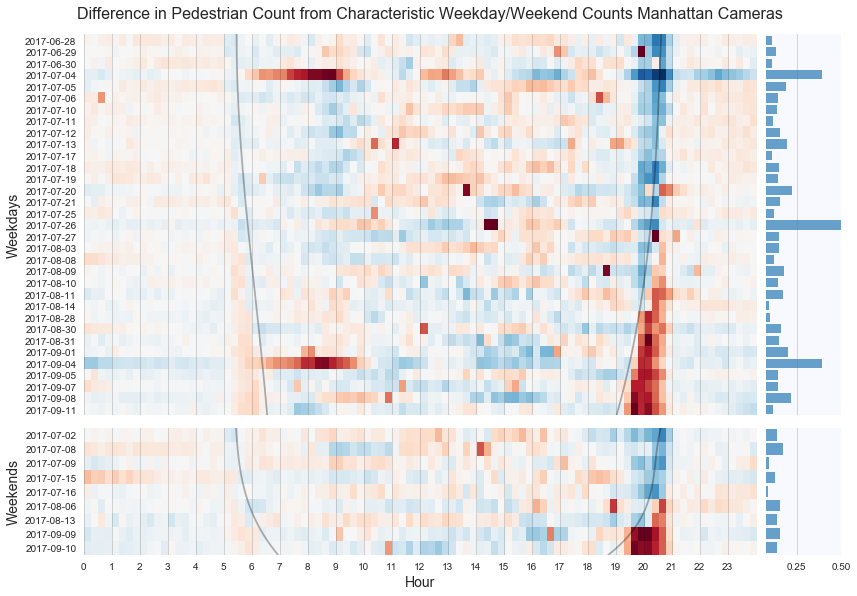

In [244]:
# -- Plot.
fig, [r1, r2] = plt.subplots(nrows=2, ncols=2, figsize=(12, 8),
                             gridspec_kw={"height_ratios": [3, 1], 
                                          "width_ratios": [9, 1]})

r1[0].get_shared_y_axes().join(r1[0], r1[1])
r2[0].get_shared_y_axes().join(r2[0], r2[1])
r2[0].get_shared_x_axes().join(r1[0], r2[0])
r1[1].get_shared_x_axes().join(r1[1], r2[1])
r1[1].set_yticklabels([])
r2[1].set_yticklabels([])
r1[0].set_xticklabels([])
r1[1].set_xticklabels([])
r1[1].set_facecolor("ghostwhite")
r2[1].set_facecolor("ghostwhite")

for (ax1, ax2), dd in zip([r1, r2], [mn_wd_ts, mn_we_ts]):
    norm_dd = ((dd.T - dd.T.mean()) / dd.T.std()).T
    anom = (norm_dd - norm_dd.mean())
    
    im = ax1.imshow(anom, cmap="RdBu", aspect="auto")
    im.set_clim(-1, 1)
    
    xx_ss, yy_ss, xx_sr, yy_sr = [], [], [], []
    for ii, idx in enumerate(pd.to_datetime(norm_dd.index)):
        sunset = nyc_astral.sun(date=idx, local=True)["sunset"]
        ss = (sunset.hour * 3600 + sunset.minute * 60 + sunset.second) / (15 * 60)
        xx_ss.append(ss)
        yy_ss.append(ii)
        sunrise = nyc_astral.sun(date=idx, local=True)["sunrise"]
        sr = (sunrise.hour * 3600 + sunrise.minute * 60 + sunrise.second) / (15 * 60)
        xx_sr.append(sr)
        yy_sr.append(ii)
    
    integ = []
    for idx in range(len(anom)):
#         integ.append(np.sqrt((anom.iloc[idx, xx_sr[-1]:xx_ss[-1]] ** 2).sum()))
        integ.append(anom.iloc[idx, xx_sr[-1]:xx_ss[-1]].std())
    
    ax2.barh(range(len(anom.index)), integ, color="#297ab5", alpha=0.7)
        
    spl_ss = UnivariateSpline(yy_ss, xx_ss)
    xs = np.linspace(-0.5, len(norm_dd) - 0.5, 100)
    ax1.plot(spl_ss(xs), xs, c="k", alpha=0.3)
    
    spl_sr = UnivariateSpline(yy_sr, xx_sr)
    ax1.plot(spl_sr(xs), xs, c="k", alpha=0.3)
    
    ax1.set_yticks(range(len(dd.index)))
    ax1.set_yticklabels(dd.index.date)

for ax in fig.get_axes():
    ax.grid(alpha=0.15, c="k")
    ax.grid(False, axis="y")
    ax.tick_params(axis="both", which="both", labelsize=10)

r1[0].set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
r2[0].set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
r2[0].set_xticklabels(range(24))
r2[0].set_xlabel("Hour", fontsize=14)
r2[1].set_xlim(0.08, 0.5)
    
r1[0].set_ylabel("Weekdays", fontsize=14)
r2[0].set_ylabel("Weekends", fontsize=14)

fig.suptitle("Difference in Pedestrian Count from Characteristic Weekday/Weekend Counts Manhattan Cameras", fontsize=16, y=1.03)
fig.tight_layout()

fig.savefig("../outputs/plots/ped_im_dail_anom_mn.png", bbox_inches='tight')

# Plot All Time Series

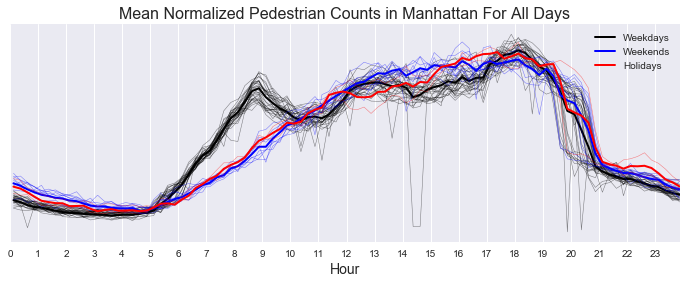

In [236]:
# -- Subselect daily timeseries from above for holidays.
mn_wd_wo_hd = wd_wo_hd[(wd_wo_hd.index.get_level_values(0).astype("float64").isin(mn_cams)) & 
                       (wd_wo_hd.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]
mn_hd = hd[(hd.index.get_level_values(0).astype("float64").isin(mn_cams)) & 
           (hd.index.get_level_values(1).isin(prec[prec.PRCP < 0.05].d.values))]

mn_wd_wo_hd_ts = mn_wd_wo_hd.groupby(level=1).mean()
mn_we_ts = mn_we.groupby(level=1).mean()
mn_hd_ts = mn_hd.groupby(level=1).mean()

# -- Plot.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
for dd, cc in zip([mn_wd_wo_hd_ts, mn_we_ts, mn_hd_ts], ["k", "b", "r"]):
    # -- Mean normalize each day.
    days = ((dd.T - dd.T.mean()) / dd.T.std())
    # -- Calculate mean day and normalize.
    mday = dd.mean()
    mday_ = ((mday - mday.mean()) / mday.std())
    
    days.plot(c=cc, alpha=0.5, lw=0.5, legend=False, ax=ax)
    mday_.plot(c=cc, lw=2, ax=ax)

ax.set_yticks([])
ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
ax.set_xticklabels(range(24))
ax.set_xlabel("Hour", fontsize=14)
ax.tick_params(axis="both", which="both", labelsize=10)
ax.set_title("Mean Normalized Pedestrian Counts in Manhattan For All Days", fontsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[i] for i in range(len(handles)) 
           if [lab == "None" for lab in labels][i]],
          ["Weekdays", "Weekends", "Holidays"])

fig.savefig("../outputs/plots/ped_line_daily_mn.png", bbox_inches='tight')

# Anomaly Regression
For this plot:
1. The mean weekday and weekend timeseries are used as regressors to calculate the daily time series' (unnormalized time series from Manhattan Day of Week Images) for each day. 
2. The resulting coefficients are plotted, with dot size reflecting the amount of rain on the given day.

__Q: Should I normalize each day's time series?__

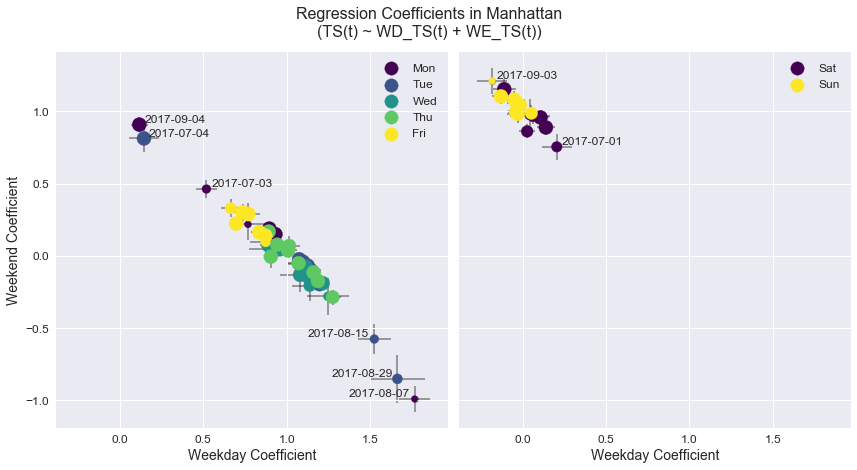

In [95]:
# -- Get cam_id for relevant cameras in Manhattan.
mn_cams = cams[(cams.boro == "Manhattan") & (cams.people == 1)].cam_id.values

# -- Subset data to relevant cameras.
mn_we = we[(we.index.get_level_values(0).astype("float64").isin(mn_cams))]
mn_wd = wd[(wd.index.get_level_values(0).astype("float64").isin(mn_cams))]

# -- Concatenate weekdays and weekends.
tmp = pd.concat([mn_wd.groupby(level=1).mean(), mn_we.groupby(level=1).mean()]).T

# -- For each day, regress against the mean weekday and weekend, saving coefficients.
data = []
for idx in tmp.columns:
    lm_df = pd.concat([tmp[idx], mn_wd.mean(), mn_we.mean()], axis=1) \
                .rename(columns={idx: "c", 0: "wd", 1: "we"})
    
    lm = smf.ols(formula="c ~ wd + we", data=lm_df).fit()
    data.append([idx, lm.params.wd, lm.params.we, lm.params.Intercept, 
                 lm.summary2().tables[1].iloc[1,1], lm.summary2().tables[1].iloc[2,1]])
data = pd.DataFrame(data, columns=["day", "wd_coef", "we_coef", "intercept", 
                                   "wd_stderr", "we_stderr"])
data = data.merge(prec, left_on="day", right_index=True)

# -- Lims for plotting
xlim = [data.wd_coef.min() - .2, data.wd_coef.max() + .2]
ylim = [data.we_coef.min() - .2, data.we_coef.max() + .2]

# -- Split to weekdays and weekends.
wd_reg = data[data.day.dt.weekday < 5]
we_reg = data[data.day.dt.weekday >= 5]

# -- Plot.
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
for ax, dd in zip([ax1, ax2], [wd_reg, we_reg]):
    grps = dd.groupby(dd.day.dt.weekday)
    color = iter(cm.viridis(np.linspace(0, 1, len(grps))))
    for nm, grp in grps:
        grp = grp.sort_values("PRCP")
        ax.errorbar(grp.wd_coef, grp.we_coef, xerr=grp.wd_stderr , yerr=grp.we_stderr, 
                    c="k", alpha=0.4, fmt="o", zorder=0)
        ax.scatter(grp.wd_coef, grp.we_coef, label=list(calendar.day_abbr)[nm],
                   c=next(color), s=(200 - 180 * np.sqrt(grp.PRCP)), zorder=1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Weekday Coefficient", fontsize=14)
    
    # -- Label point if either coefs is > 2 std dev. from the mean.
    texts = []
    for i, txt in enumerate(dd.d):
        wd_coef, we_coef = dd.wd_coef.values[i], dd.we_coef.values[i]
        if (abs(wd_coef - dd.wd_coef.values.mean()) > 1.5 * dd.wd_coef.values.std() or
            abs(we_coef - dd.we_coef.values.mean()) > 1.5 * dd.we_coef.values.std()):
            if i in [25, 31, 33]:   
                ax.text(wd_coef - 0.03, we_coef, txt, fontsize=12, va="bottom", ha="right")
            else:
                ax.text(wd_coef + 0.03, we_coef, txt, fontsize=12, va="bottom", ha="left")

    ax.tick_params(axis="both", which="both", labelsize=12)
    
    # -- Clean up the legend
    ax.legend(fontsize=12)
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*filter(lambda x: x[1] != "we_coef", zip(handles, labels)))
    ax.legend(handles, labels, fontsize=12)
    for ii in ax.legend_.legendHandles:
        ii.set_sizes([180])

ax1.set_ylabel("Weekend Coefficient", fontsize=14)
fig.suptitle("Regression Coefficients in Manhattan\n(TS(t) ~ WD_TS(t) + WE_TS(t))", fontsize=16, y=1.08)
fig.tight_layout()

fig.savefig("../outputs/plots/ped_daily_anom_reg_mn.png", bbox_inches='tight')

# Day of Week Plot

This plot shows the mean time series across a week. It is found by:
1. Taking the mean at each camera for each day at 15 minute intervals.
2. Normalizing the 'week-long' timeseries at each camera, and plotting the resulting mean.

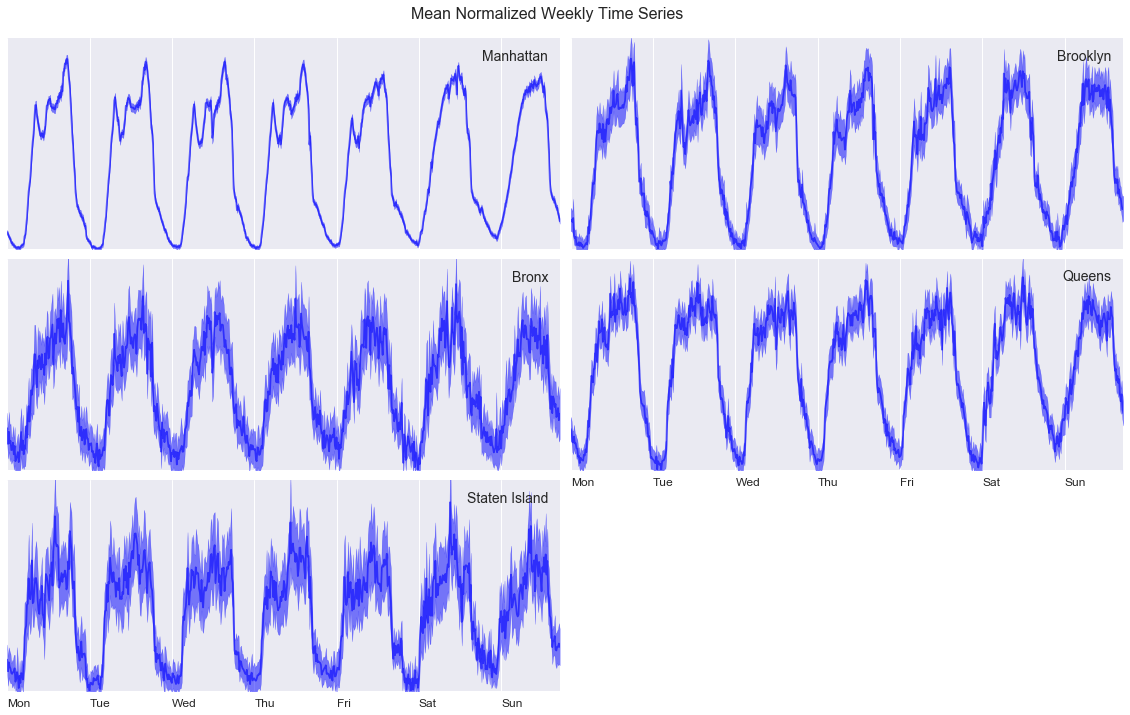

In [249]:
saved_data = True
bb = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"]
holidays = [pd.datetime(2017, 7, 4), pd.datetime(2017, 9, 4)]

# -- Plot.
fig, [r1, r2, r3] = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
fig.delaxes(r3[1])

color = iter(cm.viridis(np.linspace(0, 1, len(bb))))

for boro, ax in zip(bb, np.hstack([r1, r2, r3])):
    if not saved_data:
        # -- Select relevant cameras and exclude rain days.
        tmp = df.reset_index()[(df.reset_index().cam_id.isin(cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values))]
        tmp = tmp[tmp.d.isin(prec[prec.PRCP < 0.05].d.values) & (~tmp.d.isin(holidays))]
        tmp["d"] = tmp.d.dt.dayofweek
        tmp = tmp.groupby(["d", "cam_id"])
        tmp.mean().to_pickle("../data/results/{}_dayofweek_mean.pkl".format(boro.lower()))
        tmp.std().to_pickle("../data/results/{}_dayofweek_std.pkl".format(boro.lower()))
    
    else:
        tmp_mean = pd.read_pickle("../data/results/{}_dayofweek_mean.pkl".format(boro.lower()))
        tmp_std = pd.read_pickle("../data/results/{}_dayofweek_std.pkl".format(boro.lower()))

    tmp = (tmp_std ** 2).reset_index().drop("cam_id", axis=1).groupby("d")
    week_mean = tmp_mean.reset_index(level=1, drop=True).reset_index().groupby("d").mean().T.unstack()
    week_std_err = (np.sqrt(tmp.sum() / tmp.size().mean()) / np.sqrt(tmp.size().mean())).stack()
    
    week_mean.plot(ax=ax, c="b", alpha=0.6)
    ax.fill_between(range(len(week_mean)), week_mean + week_std_err, week_mean - week_std_err, color="b", alpha=0.5)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.grid(False, which="both", axis="y")
    ax.text(4*24*7 - 15, week_mean.max() * 1.1, boro, fontsize=14, va="top", ha="right")
    ax.set_ylim(week_mean.min(), week_mean.max() * 1.2)

for ax in [r3[0], r2[1]]:
    ax.set_xticklabels(list(calendar.day_abbr), ha="left")
    ax.tick_params(axis="both", which="both", labelsize=12)
    
fig.suptitle("Mean Normalized Weekly Time Series", fontsize=16, va="bottom", y=0.90)
fig.subplots_adjust(hspace=0.05, wspace=0.02)

fig.savefig("../outputs/plots/day_of_week_line.png", bbox_inches='tight')

# Neighborhood Time Series
This plot shows the characteristic weekly timeseries by assigned 'neighborhoods.' This is done by taking the mean normalized weekday time series at all cameras and averaging by 'neighborhood.'

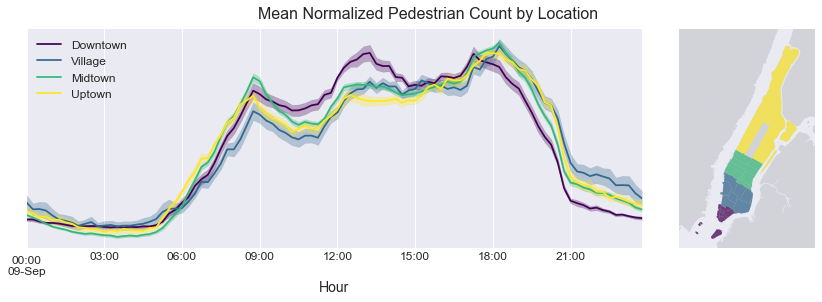

In [309]:
# -- Dictionary that assigns zipcodes to 'neighborhood'.
zip_locs = {'10115': 'uptown', '10040': 'uptown', '10075': 'uptown', '10004': 'downtown', '10005': 'downtown', '10006': 'downtown', '10007': 'downtown', '10001': 'midtown', '10002': 'village', '10065': 'uptown', '10165': 'uptown', '10069': 'uptown', '10044': 'uptown', '10275': 'uptown', '10012': 'village', '10013': 'village', '10128': 'uptown', '10028': 'uptown', '10029': 'uptown', '10026': 'uptown', '10027': 'uptown', '10024': 'uptown', '10025': 'uptown', '10022': 'midtown', '10023': 'uptown', '10020': 'midtown', '10021': 'uptown', '10010': 'midtown', '10031': 'uptown', '10003': 'village', '10011': 'village', '10030': 'uptown', '10009': 'village', '10032': 'uptown', '10014': 'village', '10282': 'downtown', '10280': 'downtown', '10281': 'downtown', '10019': 'midtown', '10018': 'midtown', '10039': 'uptown', '10038': 'downtown', '10035': 'uptown', '10034': 'uptown', '10037': 'uptown', '10036': 'midtown', '10017': 'midtown', '10016': 'midtown', '10033': 'uptown', '10111': 'midtown', '00083': 'uptown', '10048': 'downtown'}

# -- Read shapefiles for plotting
ny = gp.read_file("../data/external/nyc_shp/nybb.shp")
ny = ny.to_crs({"init": "epsg:2263"})

nj = gp.read_file("../data/external/nj_shp/New_Jersey_Counties.shp")
nj = nj.to_crs({"init": "epsg:2263"})

zc = gp.read_file("../data/external/nyc_zip/ZIP_CODE_040114.shp")
zc = zc.to_crs({"init": "epsg:2263"})
zc = zc[(zc.PO_NAME == "New York") & (zc.BLDGZIP == "0")]
zc["location"] = zc.ZIPCODE.replace(zip_locs).str.title()

# -- Select relevant cameras.
mn_cams = cams[(cams.boro == "Manhattan") & (cams.people == 1)].copy()
mn_cams["location"] = mn_cams.zipcode.replace(zip_locs).str.title()
mn_cams = mn_cams.set_index("cam_id")[["location"]]

# -- Load weekday camera time series and mean normalize.
wd = pd.read_pickle("../data/results/manhattan_wd.pkl")
wd_ = ((wd.T - wd.T.mean()) / wd.T.std()).T

# -- Merge relevant cameras with time series, groupby 'neighborhood'.
mn_ts = mn_cams.merge(wd_, left_index=True, right_index=True).groupby("location")

# -- Plot.
ts_mea = mn_ts.mean()
ts_std = mn_ts.std()
ts_siz = mn_ts.size()
std_err = ts_std.T / np.sqrt(ts_siz)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), 
                       gridspec_kw={"width_ratios":[3, 1]})

ax2.set_aspect("equal")
ax2.set_xlim(965000, 1015000)
ax2.set_ylim(185000, 265000)
ax2.grid(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

nj.plot(ax=ax2, facecolor="k", alpha=0.1)
ny.plot(ax=ax2, facecolor="k", alpha=0.1)

color = iter(cm.viridis(np.linspace(0, 1, len(ts_mea.T.columns))))
for col in ["Downtown", "Village", "Midtown", "Uptown"]:
    cc = next(color)
    ts_mea.T[col].plot(ax=ax1, c=cc)
    ax1.fill_between(ts_mea.T.index, ts_mea.T[col] + std_err[col], 
                    ts_mea.T[col] - std_err[col], color=cc, alpha=0.3)
    zc[zc["location"] == col].plot(ax=ax2, color=cc, alpha=0.7)
ax1.tick_params(axis="both", which="both", labelsize=12)  
ax1.set_xlabel("Hour", fontsize=14)
ax1.set_yticks([])
ax1.grid(True, which="both")
ax1.legend(fontsize=12, loc="upper left")
fig.suptitle("Mean Normalized Pedestrian Count by Location", fontsize=16, y=1.04)
fig.tight_layout()

fig.savefig("../outputs/plots/ped_line_neigh.png", bbox_inches='tight')

# Histogram of Values

In [ ]:
#WEEKEND AND WEEKDAY
# -- Select relevant data.
cam_id_ = 398
cc = df[df.cam_id == cam_id_]
mn_cc = df[(df.cam_id.isin(cams[(cams.boro == "Manhattan") & (cams.people == 1)].cam_id.values))]

# -- Plot.
fig = plt.figure(figsize=(12, 6))
gs1 = gridspec.GridSpec(2, 21)
gs1.update(hspace=0.05, wspace=0.5)
ax1 = plt.subplot(gs1[0, :5])
ax5 = plt.subplot(gs1[1, :5])
gs2 = gridspec.GridSpec(2, 21)
gs2.update(hspace=0.05, wspace=0.5)
ax2 = plt.subplot(gs2[0, 6:11])
ax3 = plt.subplot(gs2[0, 11:16])
ax4 = plt.subplot(gs2[0, 16:])
ax6 = plt.subplot(gs2[1, 6:11])
ax7 = plt.subplot(gs2[1, 11:16])
ax8 = plt.subplot(gs2[1, 16:])

ax2.get_shared_y_axes().join(ax2, ax3, ax4)
ax6.get_shared_y_axes().join(ax6, ax7, ax8)
ax1.get_shared_x_axes().join(ax1, ax5)
ax2.get_shared_x_axes().join(ax2, ax6)
ax3.get_shared_x_axes().join(ax3, ax7)
ax4.get_shared_x_axes().join(ax4, ax8)

for ax in [ax3, ax4, ax7, ax8]:
    ax.set_yticklabels([])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticklabels([])

cc["count"].hist(bins=len(cc["count"].unique()), ax=ax1, color="b", alpha=0.6)
ax1.set_xlim(0, cc["count"].max())

mn_cc["count"].hist(bins=len(mn_cc["count"].unique()), ax=ax5, color="b", alpha=0.6)

ax2.get_shared_y_axes().join(ax2, ax3, ax4)
ax6.get_shared_y_axes().join(ax6, ax7, ax8)

for tt, (axt, axb) in zip(["09", "12", "17"], zip([ax2, ax3, ax4], [ax6, ax7, ax8])):
    cc[cc.t.str[:2] == tt]["count"].hist(
        bins=len(cc[cc.t.str[:2] == tt]["count"].unique()), ax=axt, color="b", alpha=0.6)
    
    mn_cc[mn_cc.t.str[:2] == tt]["count"].hist(
        bins=len(mn_cc[mn_cc.t.str[:2] == tt]["count"].unique()), ax=axb, color="b", alpha=0.6)
    
    axb.set_xlim(0, cc["count"].max())

for ax, tt in zip([ax1, ax2, ax3, ax4], ["All Times", "09:00", "12:00", "17:00"]):
    ax.set_title(tt, fontsize=14)
    
for ax in fig.get_axes():
    ax.tick_params(axis="x", which="both", labelsize=12)  

ax1.set_ylabel("Camera {}\nObservations (N)".format(cam_id_), fontsize=14)
ax5.set_ylabel("Manhattan Cameras\nObservations (N)", fontsize=14)
fig.text(.5, 0.05, "Pedestrians (N) in Observation", fontsize=14, ha="center")

fig.savefig("../outputs/plots/ped_hist_mn.png", bbox_inches='tight')

# DOT Cameras

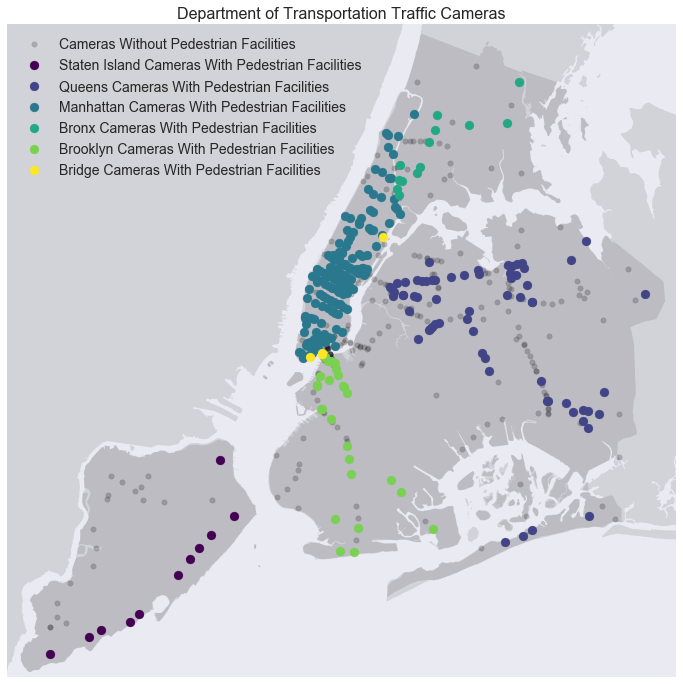

In [310]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

st = gp.read_file("../data/external/NYS_Civil_Boundaries_SHP/Counties_Shoreline.shp")
st = st.to_crs({"init": "epsg:2263"})

# -- convert cam locations to NY state plane
geometry = [Point(xy) for xy in zip(cams["long"], cams["lat"])]
cams_geo = gp.GeoDataFrame(cams, crs={'init': 'epsg:4326'}, geometry=geometry)
cams_geo = cams_geo.to_crs({"init": "epsg:2263"})

ax1.set_aspect("equal")
ax1.set_xlim(910000, 1070000)
ax1.set_ylim(119000, 275000)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

st.plot(ax=ax1, facecolor="k", alpha=0.1)
nj.plot(ax=ax1, facecolor="k", alpha=0.1)
ny.plot(ax=ax1, facecolor="k", alpha=0.1)
cams_geo[cams_geo.people == 0].plot(ax=ax1, c="k", markersize=30, 
                                    alpha=0.2, label="Cameras Without Pedestrian Facilities")

color = iter(cm.viridis(np.linspace(0, 1, 6)))
for boro in cams_geo.boro.unique():
    cams_geo[(cams_geo.people == 1) & 
             (cams_geo.boro == boro)].plot(ax=ax1, c=next(color), markersize=80,
                                           label="{} Cameras With Pedestrian Facilities".format(boro))

ax1.legend(loc="upper left", fontsize=14)
ax1.set_title("Department of Transportation Traffic Cameras", fontsize=16)

fig.savefig("../outputs/plots/dot_cameras.png", bbox_inches='tight')

# Camera Examples

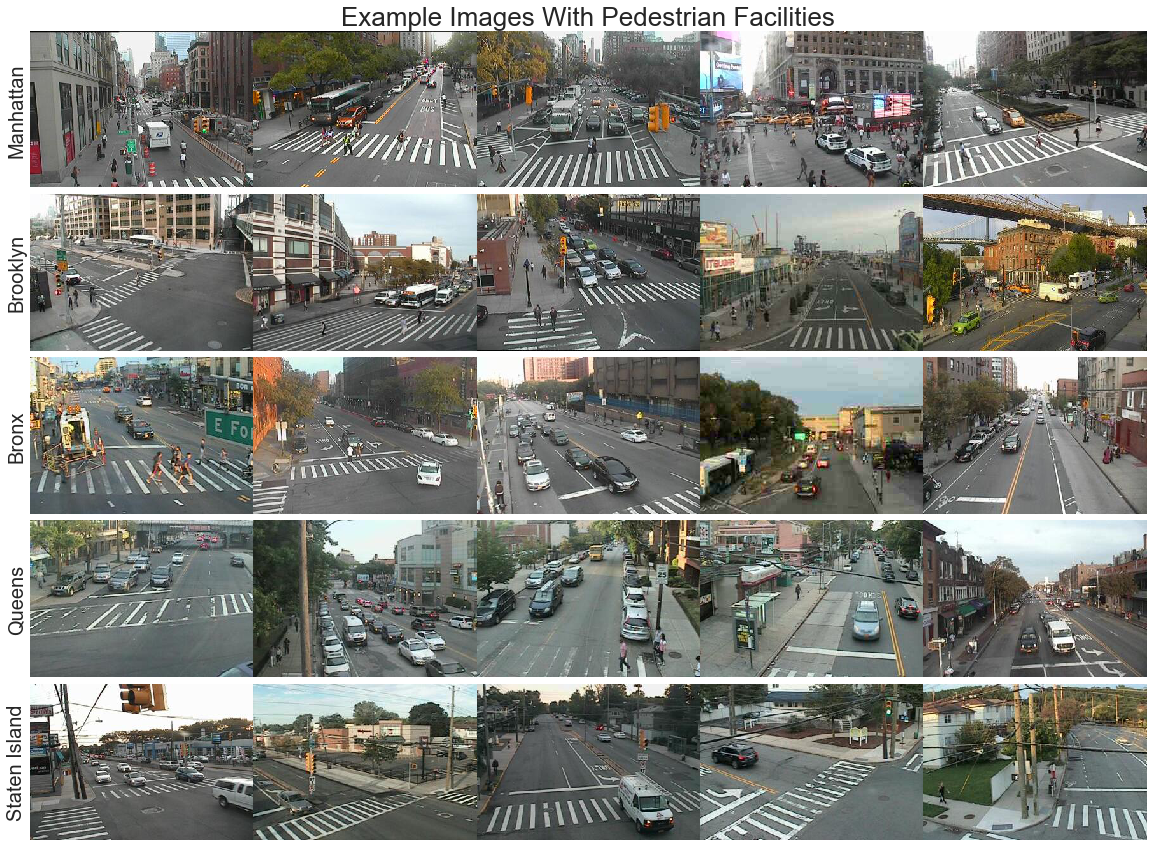

In [295]:
fig, rows = plt.subplots(nrows=5, ncols=5, figsize=(20,15))

abb = ["mn", "bk", "bx", "qn", "si"]
bb = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"]

ff = os.path.join("..", "data", "external", "people-cams")
ims = os.listdir(ff)

for rr, (b, boro) in zip(rows, zip(abb, bb)):
    boro_ims = filter(lambda x: x.endswith("{}.jpg".format(b)), ims)
    for ax, im in zip(rr, boro_ims):
        ax.imshow(mpimg.imread(os.path.join(ff, im)), aspect="equal", extent=(0, 300, 0, 210))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
    rr[0].set_ylabel(boro, fontsize=20)
    
rows[0][2].set_title("Example Images With Pedestrian Facilities", fontsize=26)
fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("../outputs/plots/people_cameras.png", bbox_inches='tight')

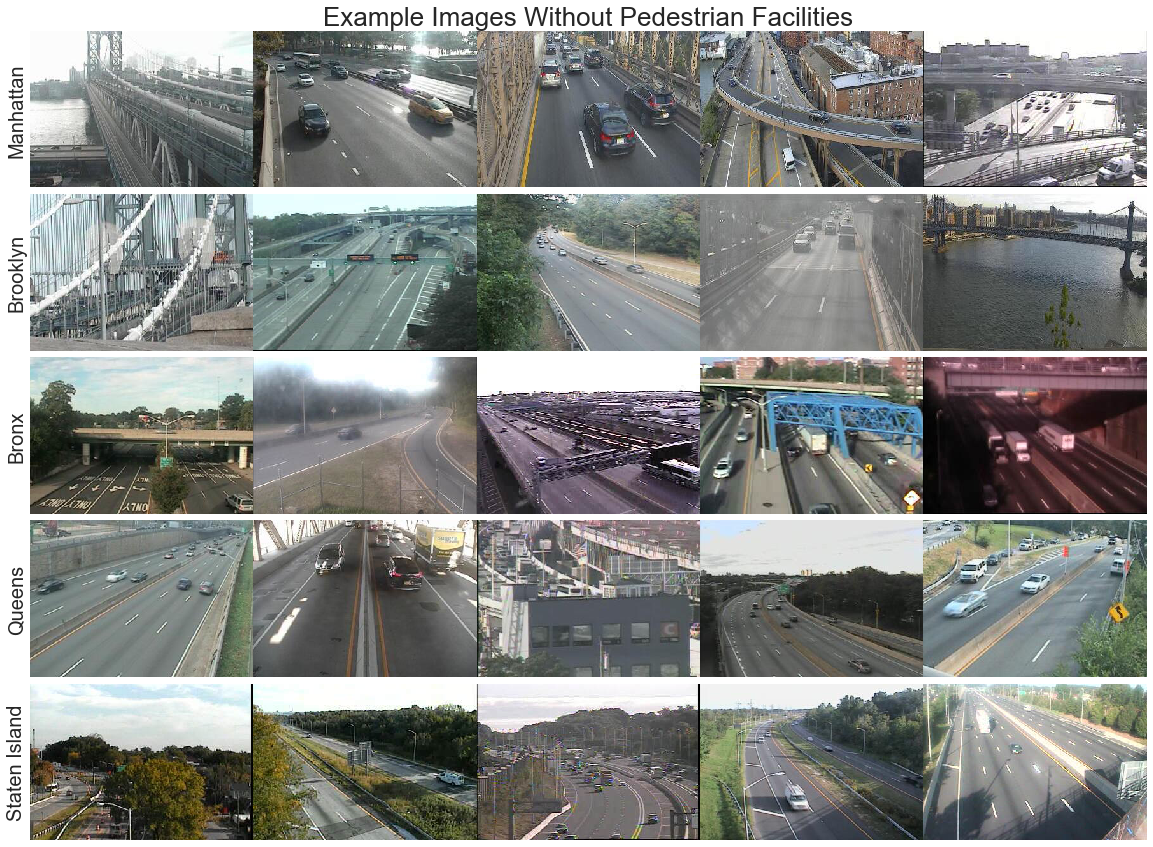

In [296]:
fig, rows = plt.subplots(nrows=5, ncols=5, figsize=(20,15))

abb = ["mn", "bk", "bx", "qn", "si"]
bb = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"]

ff = os.path.join("..", "data", "external", "no-people-cams")
ims = os.listdir(ff)

for rr, (b, boro) in zip(rows, zip(abb, bb)):
    boro_ims = filter(lambda x: x.endswith("{}.jpg".format(b)), ims)
    for ax, im in zip(rr, boro_ims):
        ax.imshow(mpimg.imread(os.path.join(ff, im)), aspect="equal", extent=(0, 300, 0, 210))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
    rr[0].set_ylabel(boro, fontsize=20)
    
rows[0][2].set_title("Example Images Without Pedestrian Facilities", fontsize=26)
fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("../outputs/plots/no_people_cameras.png", bbox_inches='tight')